In [42]:
import func
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import figure



In [18]:
df = func.make_df("Today might be the day to let your talent bloom. Maybe tomorrow or maybe some other time. But if you dont think you'll have one, you probably wont.")

In [50]:
df.head()

,depending,necessary,appropriate,inappropriate,as needed,as applicable,otherwise reasonably,sometimes,from time to time,generally,...,numerous,some,most,few,much,many,various,including but not limited to,Category,BT Coeff
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,M,2.865
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,N,2.710


In [20]:
analysis = pd.read_csv('../coef_prob_plot.csv')

In [23]:
analysis

,Unnamed: 0,bt_coef,Probablity
0,CN,1.619,0.007133
1,C,1.783,0.057405
2,CM,1.864,0.052649
3,CMN,2.125,0.004076
4,CG,2.345,0.000679
5,CGN,2.443,0.000340
6,MN,2.569,0.094090
7,N,2.710,0.112772
8,M,2.865,0.634511
9,CGMN,2.899,0.000000


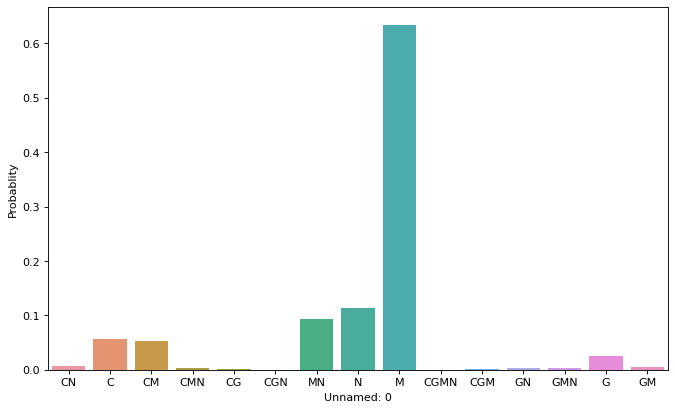

In [48]:
figure(figsize=(10, 6), dpi=80)
ax = sns.barplot(x="Unnamed: 0", y="Probablity", data=analysis)

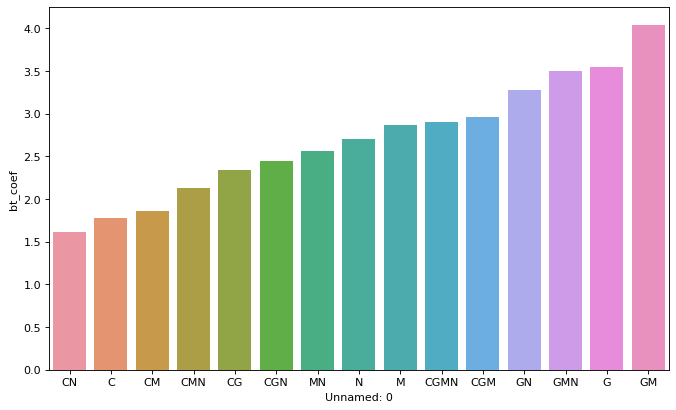

In [49]:
figure(figsize=(10, 6), dpi=80)
ax = sns.barplot(x="Unnamed: 0", y="bt_coef", data=analysis)

In [52]:
policies_data = pd.read_csv("../Policies.csv")

In [54]:
policies_data.head()

,Unnamed: 0,File_name,text_content,vague_score
0,0,GamersGLToolProwithGameTurbo&PingBooster.txt,Privacy PolicyYour privacy is important to us....,2.566222
1,1,Tasker.txt,Tasker for AndroidTaskerHomeDownloadTaskerNetU...,2.714667
2,2,PandaGamepadPro(BETA).txt,Privacy Policy of Panda Gaming StudioSearch th...,2.855882
3,3,GaanaMusicHindiSongFreeTamilTeluguMP3App.txt,Privacy PolicyThis Privacy Policy explains ou...,2.673979
4,4,WynkMusic-NewMP3HindiTamilSong&PodcastApp.txt,Privacy PolicyData CollectionAt the time you (...,2.754815


In [59]:
Company = policies_data['File_name']
rad_comp = st.selectbox("Select the Company.", Company)

for i in range(0, len(Company)):
    if rad_comp == Company[i]:
        st.dataframe(matrix.loc[Company[i], 3])
            
    st.markdown("----")

NameError: name 'rad_comp' is not defined